### The purpose of this notebook is to complete a data cleaning workflow from start to finish in order to validate the core functionality our package

#### TO DO:

- Organize code modules & tests
- Clean up/finish writing tests
- Write main script wrapper function


In [8]:
# imports

from core import *
from cpd_info import *
from mol_sim_copy import *
from pubchem_client import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## Step 1

#### Read in master dataframe



In [9]:
# read in the master_df

master_df = pd.read_csv('../datasets/MASTER_DF.csv') 
print(master_df.shape)
master_df.head()

(6879, 24)


,entry,product,reacts,PubChem,SMILES,Mol,Fingerprint,dist,enzyme_class_1,enzyme_class_2,...,enzyme_class_7,n_C,n_H,n_O,n_N,n_P,n_S,n_X,DoU,MW
0,1.8.99.5,C00094,1.0,3394,OS(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1ac9b8a210>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.000000,1,0,...,0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,82.080
1,1.13.11.18,C00094,1.0,3394,OS(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1ac9b8a580>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.511007,1,0,...,0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,82.080
2,1.8.99.5,C00283,1.0,3578,S,<rdkit.Chem.rdchem.Mol object at 0x1ac9b8ac10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.000000,1,0,...,0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,34.083
3,2.8.1.2,C00283,1.0,3578,S,<rdkit.Chem.rdchem.Mol object at 0x1ac9b8a2b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.241667,0,1,...,0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,34.083
4,4.4.1.28,C00283,1.0,3578,S,<rdkit.Chem.rdchem.Mol object at 0x1ac9b8a120>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.294605,0,0,...,0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,34.083


## Step 2 
#### Get query SMILES string & pair query compound with each unique enzyme in the master DataFrame
Example: PubChem SID 3480

In [10]:
# function to query the SMILES string and append new pairs to the master dataframe

def pair_query_compound(master_df, enzyme_col, pubchem_col, smiles_col, pubchem_sid):
    """
    pair_query_compound_with_enzymes() queries pubchem to get a SMILES string from an input pubchem_sid,
        then pairs that query compound with each unique enzyme id in the master dataframe
        
    Args:
        master_df (pandas.DataFrame): master dataframe containing enzyme ids
        enzyme_col (str): column containing enzyme id
        pubchem_col (str): column containing pubchem sid
        smiles_col (str): column containing SMILES string
        pubchem_sid (str): query PubChem sid
        
    Returns:
        pandas.DataFrame: with rows added to include query compound
    """
    master_df = master_df[[enzyme_col, pubchem_col, smiles_col]]
    new_pairs = []
    smiles, _ = sid_to_smiles(pubchem_sid)
    if len(smiles) == 0:
        raise 'query compound SMILES string could not be retrieved'
    else:
        pass
    unique_enzymes = master_df[enzyme_col].unique().tolist()
    for enzyme in unique_enzymes:
        pair = {enzyme_col:enzyme, pubchem_col:pubchem_sid, smiles_col:smiles}
        new_pairs.append(pair)
    new_paris_df = pd.DataFrame(new_pairs)
    output_df = pd.concat((master_df, new_paris_df), axis=0, sort=False)
    return output_df


In [11]:
# pair_query_compound_with_enzymes()

updated_df = pair_query_compound(master_df, 'entry', 'PubChem', 'SMILES', '3480')
print(updated_df.shape)
updated_df.head()

(7395, 3)


,entry,PubChem,SMILES
0,1.8.99.5,3394,OS(=O)O
1,1.13.11.18,3394,OS(=O)O
2,1.8.99.5,3578,S
3,2.8.1.2,3578,S
4,4.4.1.28,3578,S


## Step 3
#### Calculate molecular distances between products of the same enzyme
The model is based on the fact that we expect these distances to be closer for reactive enzyme-product pairs than for non-reactive enzyme-product pairs

In [12]:
# calculate_dist() with appended dataset

distance_df = calculate_dist(updated_df)
print(distance_df.shape)
distance_df.head()

(7395, 6)


,entry,PubChem,SMILES,Mol,Fingerprint,dist
0,1.8.99.5,3394,OS(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE38F...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.284869
1,1.13.11.18,3394,OS(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE38F...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.335205
2,1.8.99.5,3578,S,<rdkit.Chem.rdchem.Mol object at 0x000001FE38F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.284869
3,2.8.1.2,3578,S,<rdkit.Chem.rdchem.Mol object at 0x000001FE38F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.293565
4,4.4.1.28,3578,S,<rdkit.Chem.rdchem.Mol object at 0x000001FE38F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.353979


## Step 4
#### Get dummy variables to represent enzyme class
We expect that many enzyme properties could be predictive features for this model. Enzyme class should encapsulate many of these features at a high level.

In [13]:
# remove any rows that are not the query compound

reduced_df = distance_df[distance_df['PubChem'] == '3480']

In [14]:
# binarize_enzyme_class()

query_df = binarize_enzyme_class(reduced_df, 'entry')
query_df = query_df.reset_index(drop=True)
print(query_df.shape)
query_df.head()

(516, 13)


C:\Users\ellie\Documents\Data Science Classes\metamoles\code\core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]


,entry,PubChem,SMILES,Mol,Fingerprint,dist,enzyme_class_1,enzyme_class_2,enzyme_class_3,enzyme_class_4,enzyme_class_5,enzyme_class_6,enzyme_class_7
0,1.8.99.5,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.284869,1,0,0,0,0,0,0
1,1.13.11.18,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.335205,1,0,0,0,0,0,0
2,2.8.1.2,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.293565,0,1,0,0,0,0,0
3,4.4.1.28,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.353979,0,0,0,1,0,0,0
4,3.13.1.5,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.301190,0,0,1,0,0,0,0


## Step 5
#### Add in compound features with RDKit
This step uses the RDKit packages to generate descriptive features of the reaction product compounds

In [15]:
query_df = create_cpd_info(query_df)
print(query_df.shape)
query_df.head()

(516, 22)


,entry,PubChem,SMILES,Mol,Fingerprint,dist,enzyme_class_1,enzyme_class_2,enzyme_class_3,enzyme_class_4,...,enzyme_class_7,n_C,n_H,n_O,n_N,n_P,n_S,n_X,DoU,MW
0,1.8.99.5,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.284869,1,0,0,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
1,1.13.11.18,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.335205,1,0,0,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
2,2.8.1.2,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.293565,0,1,0,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
3,4.4.1.28,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.353979,0,0,0,1,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
4,3.13.1.5,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x000001FE3F0...,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.301190,0,0,1,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123


## Step 6
#### Re-Instantiate model

In [16]:
feature_df = master_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
       'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
       'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]
features = np.array(feature_df) #shape balance array for regression
reactions = list(master_df['reacts'])
feature_train, feature_test, reaction_train, reaction_test = train_test_split(features, reactions,
                                                  test_size=0.20, random_state=42)
model_1 = linear_model.LogisticRegression(solver='liblinear', penalty='l1', random_state=1, class_weight='balanced')
model_1.fit(feature_train, np.ravel(reaction_train))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

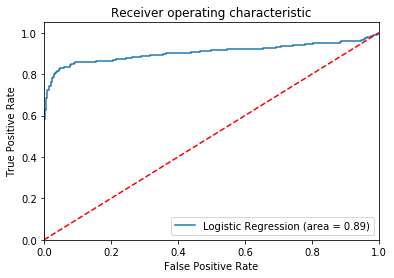

The model score is 91.93%.


In [17]:
# test the model

logit_roc_auc = roc_auc_score(reaction_test, model_1.predict(feature_test))

fpr, tpr, thresholds = roc_curve(reaction_test, model_1.predict_proba(feature_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

score = model_1.score(feature_test, reaction_test)
print('The model score is ' + str(round(score*100, 2)) + '%.')

## Step 7 
#### Use model to predict reactivity of pairs

In [11]:
# select query features

query_feat_df = query_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
       'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
       'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]

In [12]:
predictions = model_1.predict(query_feat_df) # change me to the data you want to predict based on

pred = model_1.predict_proba(query_feat_df)

prediction_values = pd.DataFrame(pred)
model_descriptive_df = pd.DataFrame()
model_descriptive_df['0']=prediction_values[0]
model_descriptive_df['1']=prediction_values[1]

In [13]:
prediction_df = pd.merge(model_descriptive_df, query_df, left_index=True, right_index=True) 
print(prediction_df.shape)
prediction_df.head()

(516, 24)


,0,1,entry,PubChem,SMILES,Mol,Fingerprint,dist,enzyme_class_1,enzyme_class_2,...,enzyme_class_7,n_C,n_H,n_O,n_N,n_P,n_S,n_X,DoU,MW
0,0.951846,0.048154,1.8.99.5,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f64ee0>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.284869,1,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
1,0.879409,0.120591,1.13.11.18,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f64d00>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.335205,1,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
2,0.948483,0.051517,2.8.1.2,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f64da0>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.293565,0,1,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
3,0.656471,0.343529,4.4.1.28,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f652b0>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.353979,0,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
4,0.951822,0.048178,3.13.1.5,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f65350>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.301190,0,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123


In [14]:
prediction_df = prediction_df.sort_values(by=['1'], ascending=False)
prediction_df.head()

,0,1,entry,PubChem,SMILES,Mol,Fingerprint,dist,enzyme_class_1,enzyme_class_2,...,enzyme_class_7,n_C,n_H,n_O,n_N,n_P,n_S,n_X,DoU,MW
359,0.201624,0.798376,1.1.1.187,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f73670>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.504968,1,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
365,0.249770,0.750230,1.3.1.115,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f73a30>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.491018,1,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
319,0.250410,0.749590,1.14.14.50,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f71cb0>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.490846,1,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
174,0.251504,0.748496,4.1.1.96,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f6be40>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.441723,0,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123
254,0.265173,0.734827,4.2.1.165,3480,C1=CC=C(C=C1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x1a23f6f350>,"[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.438121,0,0,...,0,7.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,122.123


In [7]:
#%%writefile query_model.py

# long query function that does all of the above, so that we can query it many times over with our validation data
def query_model(master_df, query_sid):
    """
    NOTE: Fields containing enzyme, compound PubChem sid, and SMILES string must be named 
        ['entry', 'PubChem', 'SMILES'] respectively
    """
    # get query SMILES string & pair query compound with each unique enzyme in the master DataFrame
    updated_df = pair_query_compound(master_df, 'entry', 'PubChem', 'SMILES', query_sid)
    # calculate molecular distances between products of the same enzyme
    distance_df = calculate_dist(updated_df)
    # remove any rows that are not the query compound
    reduced_df = distance_df[distance_df['PubChem'] == query_sid]
    # get dummy variables to represent enzyme class
    query_df = binarize_enzyme_class(reduced_df, 'entry')
    query_df = query_df.reset_index(drop=True)
    # add in compound features with RDKit
    cpd_query_df = create_cpd_info(query_df)
    
    # re-instantiate log reg model
    ######
    feature_df = master_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
           'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
           'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]
    features = np.array(feature_df) #shape balance array for regression
    reactions = list(master_df['reacts'])
    feature_train, feature_test, reaction_train, reaction_test = train_test_split(features, reactions,
                                                      test_size=0.20, random_state=42)
    model_1 = linear_model.LogisticRegression(solver='liblinear', penalty='l1', random_state=1, class_weight='balanced')
    model_1.fit(feature_train, np.ravel(reaction_train))
    ######

    # select query features
    query_feat_df = query_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
           'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
           'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]
    # query reactive enzymes 
    predictions = model_1.predict(query_feat_df) 
    pred = model_1.predict_proba(query_feat_df)
    
    # write results to a DataFrame
    prediction_values = pd.DataFrame(pred)
    model_descriptive_df = pd.DataFrame()
#     model_descriptive_df['0']=prediction_values[0]
    model_descriptive_df['p_reacts']=prediction_values[1]
    prediction_df = pd.merge(model_descriptive_df, query_df, left_index=True, right_index=True) 
    # sort DataFrame
    prediction_df = prediction_df.sort_values(by=['p_reacts'], ascending=False)
    # reset index in output dataframe
    prediction_df = prediction_df.reset_index(drop=True)
    # add rank to dataframe
    prediction_df['rank'] = prediction_df.index + 1
    # return DataFrame
    return prediction_df

Writing query_model.py


In [16]:
# read in validation data

validation_df = pd.read_csv('../datasets/validation_data.csv')
# read in smiles string data
smiles_df = pd.read_csv('../datasets/df_cleaned_kegg_with_smiles.csv', dtype='str')
# join on validation_df to get sid numbers
valid_df = pd.merge(validation_df, smiles_df, left_on='product', right_on='KEGG', how='left')
valid_df = valid_df.drop(columns=['Unnamed: 0_x', 'product', 'Unnamed: 0_y', 'entry_y', 'CID', 'SMILES'])
valid_df = valid_df.rename(columns={'entry_x': 'true_enzyme'})
valid_df = valid_df.drop_duplicates()
valid_df = valid_df.dropna(subset=['PubChem'])
valid_df = valid_df.reset_index(drop=True)
print(valid_df.shape)
valid_df.head()

(207, 3)


,true_enzyme,KEGG,PubChem
0,2.4.1.330,C19867,135626334
1,4.3.1.17,C20904,254741367
2,1.2.99.10,C21766,354339113
3,1.13.11.16,C12624,583014
4,2.1.1.324,C18033,96024253


In [17]:
# run each of these validation compounds through the query_model() function

headers = ['true_enzyme', 'KEGG', 'PubChem', 'prediction_rank', 'prediction_prob']
valid_pred_df = valid_df.reindex(columns=headers)

cpd_validation_list = valid_pred_df['PubChem'].unique().tolist()
# cpd_validation_list = ['135626334', '254741367']

for cpd in cpd_validation_list:
    try:
        prediction_df = query_model(master_df, cpd)
    except:
        pass
    handle = '../datasets/validation_data/{}.csv'.format(cpd)
    prediction_df.to_csv(handle, index=False)
    for index, row in valid_pred_df.loc[valid_pred_df.loc[:, 'PubChem'] == cpd].iterrows():
        enzyme = row['true_enzyme']
        for _, pred_row in prediction_df.loc[prediction_df.loc[:,'entry'] == enzyme].iterrows():
            valid_pred_df.loc[index, 'prediction_rank'] = pred_row['rank']
            valid_pred_df.loc[index, 'prediction_prob'] = pred_row['p_reacts']
    valid_pred_df.to_csv('validation_summary.csv', index=False)

valid_pred_df.head()

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]
/Users/stephenblaskowski/projects/metamoles/code/core.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,true_enzyme,KEGG,PubChem,prediction_rank,prediction_prob
0,2.4.1.330,C19867,135626334,12.0,0.407509
1,4.3.1.17,C20904,254741367,16.0,0.774217
2,1.2.99.10,C21766,354339113,6.0,0.700550
3,1.13.11.16,C12624,583014,383.0,0.122631
4,2.1.1.324,C18033,96024253,434.0,0.071416


In [18]:
valid_pred_df.head()

,true_enzyme,KEGG,PubChem,prediction_rank,prediction_prob
0,2.4.1.330,C19867,135626334,12.0,0.407509
1,4.3.1.17,C20904,254741367,16.0,0.774217
2,1.2.99.10,C21766,354339113,6.0,0.700550
3,1.13.11.16,C12624,583014,383.0,0.122631
4,2.1.1.324,C18033,96024253,434.0,0.071416


## Out of curiosity:
#### Examine average molecular distance distributions for negative and positive data
On first glance, it appears that our hypothesis is correct in that the distributions of average molecular distances are qualitatively different between the positive and negative datasets

In [ ]:
# look at distributions of distances for positive and negative data

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

pos = sns.distplot(distance_df['dist'], bins=50, kde=False, ax=axes[0])
axes[0].set_title('positive data avg. mol. dist.')

neg = sns.distplot(distance_df['dist'], bins=50, kde=False, ax=axes[1])
axes[1].set_title('negative data avg. mol. dist.')

for axis in axes:
    axis.set_xlim([0.0, 1.0])